In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import scipy as sc
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import seaborn as sns

In [2]:
'''
Filter method to perform feature selection
@param X - data inputs (pandas Dataframe)
       y - data targets (pandas DataFrame)
       threshold - correlation value to be above to be selected as feature
       feature_type - either "MEAN" or "MEDI" to indicate what type of features to include
@return features - selected features (list)
'''
def Filter(X, y, num_features):
    # filter feature names to only include those that contain "MEAN" or "MEDI"

    names = [col for col in X.columns]
    X_filtered = X[names]
    X_filtered = X

    mi = mutual_info_regression(X_filtered, y)
    mi = pd.Series(mi)
    mi.index = names
    top_mi = mi.sort_values(ascending=False)[:num_features]

    return top_mi.sort_values(ascending=False)



In [11]:
# importing dataset
with open('ejle_nonan_df.pkl', 'rb') as file:
    df = pickle.load(file)

file.close()

df = df.drop(df.columns[:3], axis=1)

# Selecting X variables by excluding unwanted columns
# exclusing STATE_NAME, ST_ABBREV, CITY_NAME, LE_MEAN, LE_MEDI
X_dem = df.drop(['LE_MEAN', 'LE_MEDI'], axis=1)

# creating separate y target variables
    # y_mean = life expectancy mean
    # y_median = life expectancy median
y_mean_dem = df['LE_MEAN']
y_median_dem = df['LE_MEDI']

In [12]:
# importing dataset
with open('EJSLE_mnmdstdv_demoend.pkl', 'rb') as file:
    df = pickle.load(file)

file.close()

y_mean_env = df['LE_MEAN']
y_median_env = df['LE_MEDI']

# Selecting X variables by excluding unwanted columns
# exclusing STATE_NAME, ST_ABBREV, CITY_NAME, LE_MEAN, LE_MEDI
X_env = df.drop(['LE_MEAN', 'LE_MEDI'], axis=1)
X_env = X_env.drop(X_env.columns[:3], axis=1)

# excluding all demographic columns 
X_env = X_env.loc[:, :'P_PWDIS_D2_STDV']

#### MI-Ranked Features with Linear Regression

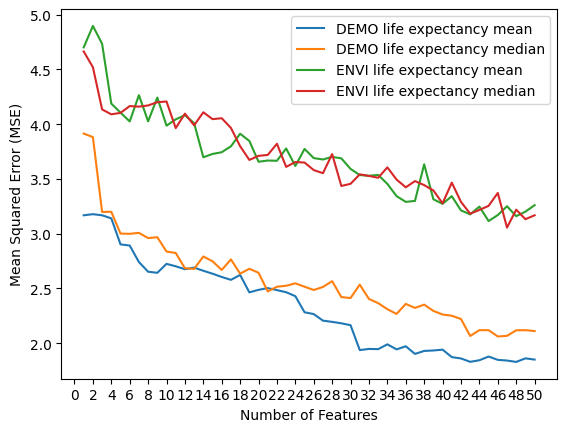

In [5]:
targets = [y_mean_dem, y_median_dem, y_mean_env, y_median_env]
target_names = ["DEMO life expectancy mean", "DEMO life expectancy median", "ENVI life expectancy mean", "ENVI life expectancy median"]
colors = plt.cm.tab10(np.arange(10))
k_folds = [5]
for idx, target in enumerate(targets):
    mse_mean = []
    for i in range(1, 51):
        if (idx == 0 or idx == 1):
            X = X_dem
        if (idx == 2 or idx == 3):
            X = X_env
        # Convert the Pandas Series to a list of column names
        mean_features = Filter(X, target, i)
        selected_features = list(mean_features.index)[:i]

        # Select only the rows of X that have column names in mean_features
        X_select = X.loc[:, selected_features]
        
        # create copy of these to keep indexing correct in kfold cv below
        X_train_copy = X_select.copy()
        y_train_copy = target.copy()
        
        
        # perform k_folds for k = 3, 5, 10
        #k_folds = [3, 5, 10]
        k = [5]
        for k in k_folds:
            scores = [] 
            rmse_list = [] 
            mse_list = []
            lrmodel = LinearRegression()
            cv = KFold(n_splits=k, shuffle=True)
            for train_index, test_index in cv.split(X_train_copy):
                X_train, X_test = X_train_copy.iloc[train_index], X_train_copy.iloc[test_index]
                y_train_fold, y_test_fold = y_train_copy.iloc[train_index], y_train_copy.iloc[test_index] # use y_train_copy
                lrmodel.fit(X_train, y_train_fold)
                y_predict = lrmodel.predict(X_test)
                scores.append(r2_score(y_test_fold, y_predict))
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict)))
                mse_list.append(mean_squared_error(y_test_fold, y_predict))
        mse_mean.append(np.mean(mse_list))

        

    plt.plot(range(1, 51), mse_mean, color=colors[idx], label=target_names[idx])
    

plt.xlabel("Number of Features")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks(range(0,51, 2))
plt.legend()
plt.show()

In [13]:
# importing dataset
with open('ejle_nonan_df.pkl', 'rb') as file:
    df = pickle.load(file)

file.close()

df = df.drop(df.columns[:3], axis=1)

# Selecting X variables by excluding unwanted columns
# exclusing STATE_NAME, ST_ABBREV, CITY_NAME, LE_MEAN, LE_MEDI
X_dem = df.drop(['LE_MEAN', 'LE_MEDI'], axis=1)

# creating separate y target variables
    # y_mean = life expectancy mean
    # y_median = life expectancy median
y_mean_dem = df['LE_MEAN']
y_median_dem = df['LE_MEDI']

In [14]:
# importing dataset
with open('EJSLE_mnmdstdv_demoend.pkl', 'rb') as file:
    df = pickle.load(file)

file.close()

y_mean_env = df['LE_MEAN']
y_median_env = df['LE_MEDI']

# Selecting X variables by excluding unwanted columns
# exclusing STATE_NAME, ST_ABBREV, CITY_NAME, LE_MEAN, LE_MEDI
X_env = df.drop(['LE_MEAN', 'LE_MEDI'], axis=1)
X_env = X_env.drop(X_env.columns[:3], axis=1)

# excluding all demographic columns 
X_env = X_env.loc[:, :'P_PWDIS_D2_STDV']

In [15]:
# Normalizing the data to mean = 0 and variance = 1
def normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / std
    return X

X_dem = normalization(X_dem)
X_env = normalization (X_env)

# Apply PCA to the training data to get 95% variance
pca_dem = PCA(n_components=0.95)
X_pca_dem = pca_dem.fit_transform(X_dem)
pca_env = PCA(n_components=0.95)
X_pca_env = pca_env.fit_transform(X_env)

#### KNN for PCA

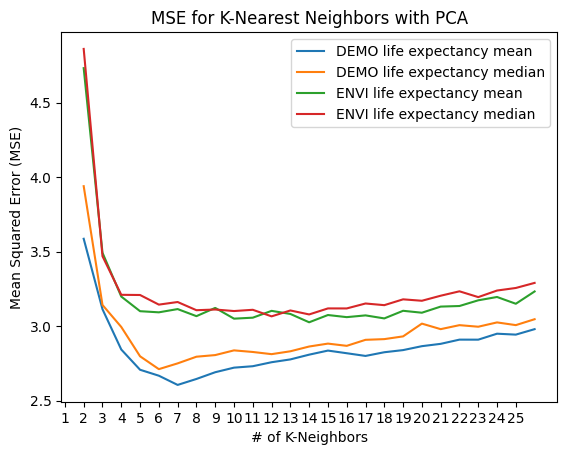

In [17]:
targets = [y_mean_dem, y_median_dem, y_mean_env, y_median_env]
target_names = ["DEMO life expectancy mean", "DEMO life expectancy median", "ENVI life expectancy mean", "ENVI life expectancy median"]
colors = plt.cm.tab10(np.arange(10))
for idx, target in enumerate(targets):
    if idx == 0 or idx == 1:
        # create copy of these to keep indexing correct in kfold cv below
        X_copy = X_pca_dem.copy()
    elif idx == 2 or idx == 3:
        X_copy = X_pca_env.copy()
    y_copy = target.copy().to_numpy().reshape(-1, 1)
    # Normalize the data to mean = 0 and variance = 1
    X_train_norm = normalization(X_copy)
    mse_mean = []

    # perform k_folds for k = 3, 5, 10
    #k_folds = [3, 5, 10]
    k = [5]
    # perform for degrees 2, 3, 4, 5
    neighbors = list(range(1, 26))
    for k in k_folds:
        for n in neighbors:
            rmse_list = [] # to store RMSE
            mse_list = []
            knn_model = KNeighborsRegressor(n_neighbors=n)
            cv = KFold(n_splits=5, shuffle=True)
            for train_index, test_index in cv.split(X_train_norm):
                X_train_fold, X_test_fold = X_train_norm[train_index], X_train_norm[test_index]
                y_train_fold, y_test_fold = y_copy[train_index], y_copy[test_index]
                knn_model.fit(X_train_fold, y_train_fold)
                y_predict_norm = knn_model.predict(X_test_fold)
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict_norm)))
                mse_list.append(mean_squared_error(y_test_fold, y_predict_norm))

            mse_mean.append(np.mean(mse_list))

            
            
    plt.plot(neighbors, mse_mean, color=colors[idx], label=target_names[idx])
    
plt.xlabel("# of K-Neighbors")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks(range(len(neighbors)), [str(n) for n in neighbors])
plt.title("MSE for K-Nearest Neighbors with PCA")
plt.legend()
plt.show()

#### SVR for PCA

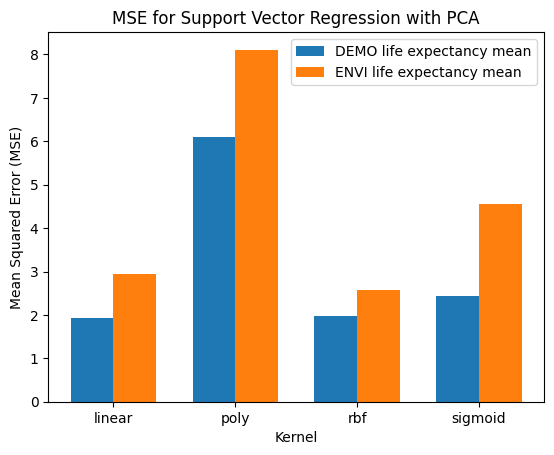

In [18]:
targets = [y_mean_dem, y_mean_env]
target_names = ["DEMO life expectancy mean", "ENVI life expectancy mean"]
colors = plt.cm.tab10(np.arange(10))
data = [X_pca_dem, X_pca_env]
# perform for different kernels
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
bar_width = 0.35
bar_positions = np.arange(len(kernel))

fig, ax = plt.subplots()
for idx, target in enumerate(targets):
    # create copy of these to keep indexing correct in kfold cv below
    X_copy = data[idx].copy()
    y_copy = target.copy().to_numpy().reshape(-1,)
    # Normalize the data to mean = 0 and variance = 1
    X_train_norm = normalization(X_copy)
    mse_mean = []



    # perform k_folds for k = 3, 5, 10
    #k_folds = [3, 5, 10]
    k = [5]
  
    for k in k_folds:
        for ker in kernel:
            rmse_list = [] # to store RMSE
            mse_list = []
            svr_model = SVR(kernel=ker)
            cv = KFold(n_splits=k, shuffle=True)
            for train_index, test_index in cv.split(X_train_norm):
                X_train_fold, X_test_fold = X_train_norm[train_index], X_train_norm[test_index]
                y_train_fold, y_test_fold = y_copy[train_index], y_copy[test_index]
                svr_model.fit(X_train_fold, y_train_fold)
                y_predict_norm = svr_model.predict(X_test_fold)
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_predict_norm)))
                mse_list.append(mean_squared_error(y_test_fold, y_predict_norm))

            mse_mean.append(np.mean(mse_list))

            
    # plot the bar for this target
    ax.bar(bar_positions + idx * bar_width, mse_mean, width=bar_width, color=colors[idx], label=target_names[idx])

# set labels, title and legend
ax.set_xlabel('Kernel')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE for Support Vector Regression with PCA')
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(kernel)
ax.legend()

plt.show()

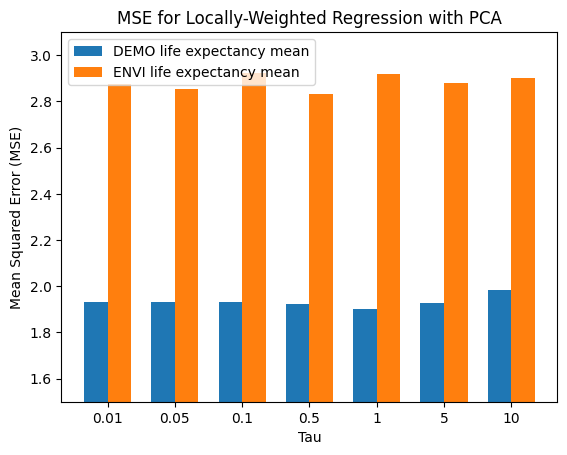

In [20]:
def local_regression(xi, X, y, tau):
    m = X.shape[0]
    W = np.zeros((m,m))
    # fill in the weight matrix
    for i in range(m):
        xit = np.concatenate(([1], X[i, :]))  # add a 1 to the beginning of xit
        xi_ = np.concatenate(([1], xi[0, :]))  # add a 1 to the beginning of xi
        W[i, i] = np.exp(-np.dot((xi_ - xit), (xi_ - xit).T) / (2 * tau * tau))
    W += 1e-8 * np.identity(m)  # add a small constant to the diagonal to avoid zero weights
    W = W / np.sum(W, axis=0)  # normalize the weights
    lrmodel = LinearRegression()
    lrmodel.fit(X, y, sample_weight=W.diagonal())
    return lrmodel.predict(xi.reshape(1, -1))



targets = [y_mean_dem, y_mean_env]
target_names = ["DEMO life expectancy mean", "ENVI life expectancy mean"]
colors = plt.cm.tab10(np.arange(10))
data = [X_pca_dem, X_pca_env]

# perform k_folds for k = 3, 5, 10
#k_folds = [3, 5, 10]
k_folds = [5]
# define a list of bandwidths to try
tau_list = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
bar_width = 0.35
bar_positions = np.arange(len(tau_list))
fig, ax = plt.subplots()
for idx, target in enumerate(targets):
    # create copy of these to keep indexing correct in kfold cv below
    X_copy = data[idx].copy()
    y_copy = target.copy().to_numpy().reshape(-1, 1)

    mse_mean = []


    for k in k_folds:
        for tau in tau_list:
            scores = [] # to store r squared
            rmse_list = [] # to store RMSE
            mse_list = []

            kf = KFold(n_splits=k, shuffle=True)
            for train_index, test_index in kf.split(X_copy):
                X_train_fold, X_test_fold = X_copy[train_index], X_copy[test_index]
                y_train_fold, y_test_fold = y_copy[train_index], y_copy[test_index]

                # Create a copy of y_train_fold
                y_train_fold_copy = y_train_fold.copy()

                y_pred_fold = np.zeros(len(X_test_fold))
                for i in range(len(X_test_fold)):
                    y_pred_fold[i] = local_regression(X_test_fold[i].reshape(1,-1), X_train_fold, y_train_fold_copy, tau)

                scores.append(r2_score(y_test_fold, y_pred_fold))
                rmse_list.append(np.sqrt(mean_squared_error(y_test_fold, y_pred_fold)))
                mse_list.append(mean_squared_error(y_test_fold, y_pred_fold))
            mse_mean.append(np.mean(mse_list))

            
            
        # plot the bar for this target
    ax.bar(bar_positions + idx * bar_width, mse_mean, width=bar_width, color=colors[idx], label=target_names[idx])

# set labels, title and legend
ax.set_xlabel('Tau')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE for Locally-Weighted Regression with PCA')
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(tau_list)
ax.legend()
ax.set_ylim([1.5, 3.1])
plt.show()